Convolutional Neural Network (CNN) is a type of neural network commonly used in computer vision. CNN uses convolutions layers to detect image features. Within a convolution layer, a **kernel**/**filter** is applied to an image, which produces a **feature map**/**activation map**. Next, use **pooling** to scale down the activation map. Two common techniques of pooling are **max pooling** and **average pooling**.

Here we start with a reduced MNIST dataset to classify digit 3 and 7. Then we will expand to all ten digits towards the end.

# Kernel

In [43]:
import torch

In [44]:
# !wget "https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz" -O "../data/mnist_sample.tgz" && tar -xzf "../data/mnist_sample.tgz" -C ../data/
# !wget "https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz" -O "../data/mnist_png.tgz" && tar -xzf "../data/mnist_png.tgz" -C ../data/

In [45]:
from pathlib import Path

sample_path = Path("../data/mnist_sample")
print(list(sample_path.iterdir()))


[PosixPath('../data/mnist_sample/labels.csv'), PosixPath('../data/mnist_sample/valid'), PosixPath('../data/mnist_sample/train')]


In [46]:
from PIL import Image

im3 = Image.open(sample_path / "train" / "3" / "12.png")
im3


In [47]:
from numpy import array

im3_t = torch.as_tensor(array(im3))
im3_t[3:10, 5:10]


tensor([[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [ 91, 142, 155, 246, 182],
        [254, 254, 254, 254, 254],
        [254, 254, 235, 189, 189],
        [ 35,  35,  25,   0,   0],
        [  0,   0,   0,   0,   0]], dtype=torch.uint8)

We define a 3 x 3 matrix, it serves as a **kernel** in CNN. It is responsible for detecting image features. We define a kernel that detect top edge of an object. To apply on kernel on an image, we perform **element-wise multiplication** (`*` in pytorch). This kernel has -1s on the top row and 1s on third row. What this says is if the image has greater values on the bottom than top, we get a large positive number after we apply the kernel.

In [48]:
top_edge = torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).float()

We pick the part of the image that has a top edge, boundary of the figure 3, and apply the kernel. We get a large number:

In [49]:
(im3_t[4:7, 6:9] * top_edge).sum()

tensor(762.)

We will simplify that process with a func

In [50]:
def apply_kernel(row, col, kernel):
    return (im3_t[row - 1 : row + 2, col - 1 : col + 2] * kernel).sum()

To apply a kernel on an image, we swipe it scans an image one position at a time. We use nested list comprehension to call `apply_kernel` iteratively. This will give all all top edges of the image:

In [51]:
import matplotlib.pyplot as plt
import numpy as np


def show_image(im, title=None, **kwargs):
    """
    Show a PIL, NumPy array, or PyTorch tensor image on matplotlib axes.

    Args:
        im: Image as PIL.Image, numpy.ndarray, or torch.Tensor
        title: string title for the image (optional)
        **kwargs: additional arguments passed to ax.imshow()
    """

    # Handle PyTorch tensors
    if hasattr(im, "data") and hasattr(im, "cpu") and hasattr(im, "permute"):
        im = im.data.cpu()
        # Convert to numpy
        if hasattr(im, "numpy"):
            im = im.numpy()
        else:
            im = np.array(im)
        # Handle channel-first format (C, H, W) -> (H, W, C)
        if (
            len(im.shape) == 3 and im.shape[0] < 5
        ):  # Assume channels first if first dim < 5
            im = np.transpose(im, (1, 2, 0))

    # Handle single channel images (squeeze last dimension if it's 1)
    if len(im.shape) == 3 and im.shape[-1] == 1:
        im = im.squeeze(-1)

    # Calculate default figure size based on image dimensions
    height, width = im.shape[:2]
    max_size = 1
    if height > width:
        figsize = (max_size * width / height, max_size)
    else:
        figsize = (max_size, max_size * height / width)

    fig, ax = plt.subplots(figsize=figsize)

    if "cmap" not in kwargs:
        kwargs["cmap"] = "Grays"

    # Display the image
    ax.imshow(im, **kwargs)

    ax.axis("off")
    # Set title if provided
    if title is not None:
        ax.set_title(title)


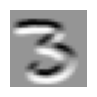

In [52]:
rng = range(1, 27)
top_edge3 = torch.tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_edge3)

Here, we can see the top boundaries of the figure 3 are darker, since the kernel has identified those parts of the image as top edge.

As another example, we define a left edge kernel and apply it to the same image.

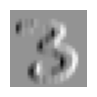

In [53]:
left_edge = torch.tensor([[-1, 1, 0], [-1, 1, 0], [-1, 1, 0]]).float()

left_edge3_tensor = torch.tensor(
    [[apply_kernel(i, j, left_edge) for j in rng] for i in rng]
)

show_image(left_edge3_tensor);


# Create a convolution in Pytorch 

Now we use pytorch to create a CNN: `F.conv2d(input, weight)`, where input is the input tensor of shape `(minibatch, in_channels, iH, iW)` and weight is filters of shape `(out_channels, in_channels, kH, kW)`. **Channel** is the number of basic color to represent an image. In our case, we use greyscale for training images, which means our input channel is 1. We will create 4 kernels, so we can detect 4 features, therefore our output channel is 4. Note that pytorch represent images with dimension `(channels, height, width)`

In [56]:
diag1_edge = torch.tensor([[0, -1, 1], [-1, 1, 0], [1, 0, 0]]).float()
diag2_edge = torch.tensor([[1, -1, 0], [0, 1, -1], [0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

Notice that the kernel shape has rank 3, missing the `in_channels` param. We use `unsqueeze` to add a new dimension of size 1 at position 1.

In [57]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [58]:
edge_kernels = edge_kernels.unsqueeze(1)

Next, we create dataloaders for the images with minibatch size of 64

In [59]:
from pathlib import Path

import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


class MNISTDataset(Dataset):
    """Custom Dataset for loading MNIST images from directory structure"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Get all image files
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            if class_dir.is_dir():
                for img_file in class_dir.glob("*.png"):
                    self.images.append(str(img_file))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image as PIL Image (grayscale)
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        return image, label


def create_mnist_dataloaders(path, batch_size=64):
    path = Path(path)

    # Define transforms
    transform = transforms.Compose(
        [
            transforms.ToTensor(),  # Convert PIL to tensor and normalize to [0, 1]
        ]
    )

    # Check if train and valid directories exist
    train_path = path / "train" if (path / "train").exists() else path / "training"
    valid_path = path / "valid" if (path / "valid").exists() else path / "testing"

    if train_path.exists() and valid_path.exists():
        train_dataset = MNISTDataset(train_path, transform=transform)
        print(train_dataset.class_to_idx)
        print("train set len, ", len(train_dataset.images))
        valid_dataset = MNISTDataset(valid_path, transform=transform)
        print(valid_dataset.class_to_idx)
        print("valid set len, ", len(valid_dataset.images))

    else:
        print("Using existing train/valid split")

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, valid_loader

Now take a look at the input dataset's shape

In [60]:
train_loader, valid_loader = create_mnist_dataloaders("../data/mnist_sample")

xb, yb = next(iter(train_loader))
xb.shape

{'3': 0, '7': 1}
train set len,  12396
{'3': 0, '7': 1}
valid set len,  2038


torch.Size([64, 1, 28, 28])

Now we are ready to create a convolutional layer. Notice that it gives use individuals images of shape (4, 26, 26), where each image has 4 out channels (4 edges). Notice the output image has height and width of 26, this is because the filters cannot give use the same shape without padding on the edges.

In [61]:
import torch.nn as nn
import torch.nn.functional as F

batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

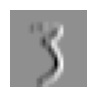

In [62]:
show_image(batch_features[1, 0])

# Math of the convolution layer

A crucial aspect of CNN is to figure out the shape of the **activation map** (output of the convolution) after a kernel is applied. For example, for a 5 x 5 image, applying a 3 x 3 kernel gives a 2 x 2 activation map. As shown in the gif, a 6 x 6 image turns into a 4 x 4 activation map after applying a 3 x 3 kernel.

TODO: image

Oftentimes, we want the activation map the same size as the input image. To do that we need to add **padding** grids on each side of the input image. If the kernel size is `ks` by `ks`, we need add `ks//2` padding on each side to keep the activation map the same shape. In our previous example, our kenels are 3 x 3, we need `3 // 2 = 1` padding on each side of the original image to keep the same dimension.

To reduce the size of the activation map, we use **stride**, which means we move the kernel in steps of n instead of 1 grid at a time. When we take stripe of 2, we reduce the size of one side by 1/2, which means the activation map is 1/4 the original size.

In general, the formula for each dimension is `(n + 2*pad - ks)//stride + 1`, where `n` is the size of the original image on that dimension, `pad` is the padding, `ks`, the size of our kernel, and `stride` is the stride. For example, with a 5×5 input, 4×4 kernel, and 2 pixels of padding, we have `(5 + 2 * 2 - 4)//1 + 1 = 5//1 + 1 = 6`, as shown in the image below TODO: image

# Create a CNN

In Pytorch, a convolution layer is `nn.Conv2d`, where it takes  `(in_channels, out_channels, kernel_size)` for required args. It initializes weight matrix automatically.

In [63]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1),
)
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

This CNN won't be able to classify our digits, since the final activation is 28 x 28. To perform classification, we need a single output with 2 levels (3 and 7). To achieve that, we use `stride=2` to reduce the size of the activation maps. We create a helper function to create convolution layer as well as an optional activation function.

In [64]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res


The stride 2 is baked into the `conv` definition. For our cnn, we add more layers to compensate for the fact that the activation maps are getting smaller. Notice the `Flatten` function removes the extra 1 x 1 dimension.

In [65]:
simple_cnn = nn.Sequential(
    conv(1, 4),  # 14x14
    conv(4, 8),  # 7x7
    conv(8, 16),  # 4x4
    conv(16, 32),  # 2x2
    conv(32, 2, act=False),  # 1x1
    nn.Flatten(),
)

Below is the a summary from the fastai learner's summary() function:

```
Sequential (Input shape: ['64 x 1 x 28 x 28'])
================================================================
Layer (type)         Output Shape         Param #    Trainable 
================================================================
Conv2d               64 x 4 x 14 x 14     40         True      
________________________________________________________________
ReLU                 64 x 4 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       296        True      
________________________________________________________________
ReLU                 64 x 8 x 7 x 7       0          False     
________________________________________________________________
Conv2d               64 x 16 x 4 x 4      1,168      True      
________________________________________________________________
ReLU                 64 x 16 x 4 x 4      0          False     
________________________________________________________________
Conv2d               64 x 32 x 2 x 2      4,640      True      
________________________________________________________________
ReLU                 64 x 32 x 2 x 2      0          False     
________________________________________________________________
Conv2d               64 x 2 x 1 x 1       578        True      
________________________________________________________________
Flatten              64 x 2               0          False     
________________________________________________________________

Total params: 6,722
Total trainable params: 6,722
Total non-trainable params: 0
```

We interpret the shape as `batch,channel,height,width`. Notice that the # of parameters are increasing, this compensate the fact that the activation maps are getting smaller. Let's see why that's needed.

We look at the first layer of this cnn, the output shape is 14 x 14. The next layer has 296 parameters. These weights include n_channel = n_bias bias weights. In this case, we 8 bias weights. So each activation in the map will multiply 296 - 8 parameters, which is 14 * 14 * 288 = 56448 operations

For the next layer, we have 1169 - 16 params as well as 4 x 4 activation maps. This gives us 1153 * 4 * 4 = 56448 operations, which equals the operation we perform in the previous layer.

So although we decreased the output dimension, we does not decrease the amount of computation we perform. Since later layers computer more complex features, this is the desired outcome. As a rule of thumb, we generally want to double the number of filters each time we have a stride-2 layer.

> Note that the terms here are a big confusing. Sometimes channels are called features or filters when they are not input channels. TODO: reformat in blog

Below is how to count the total params of a layer, parameters of its weight and bias.

In [66]:
m = simple_cnn[0]
out = m(xb)  # xb is your input batch
param_count = sum(p.numel() for p in m.parameters())
print(f"Parameter count for simple_cnn[0]: {param_count}")
for p in m.parameters():
    print(p.numel())

Parameter count for simple_cnn[0]: 40
36
4


Finally, we apply the cnn to a training batch and look at its shape.

In [67]:
simple_cnn(xb).shape, simple_cnn(xb)[:10]

(torch.Size([64, 2]),
 tensor([[0.0364, 0.0341],
         [0.0370, 0.0353],
         [0.0365, 0.0352],
         [0.0371, 0.0348],
         [0.0371, 0.0330],
         [0.0364, 0.0356],
         [0.0379, 0.0349],
         [0.0356, 0.0335],
         [0.0360, 0.0343],
         [0.0342, 0.0342]], grad_fn=<SliceBackward0>))

This is exactly what we want, for each of the 64 images in a batch, we got two scores, logits, each corresponds to a digit.

We pick an image from the training batch.

(torch.Size([64, 1, 28, 28]), None)

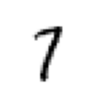

In [68]:
xb.shape, show_image(xb[3, 0])

We convert the logits to probability and we can see that the classification with higher probability is 0, which according to our dataset (`class_to_idx`) above, is 3. This is an incorrect classification. We will see if the training improves the result.

In [69]:
logits = simple_cnn(xb)  # [64, 2]
probs = logits.softmax(dim=1)  # [64, 2], rows sum to 1
preds = probs.argmax(dim=1)
logits[3], probs[3], preds[3]

(tensor([0.0371, 0.0348], grad_fn=<SelectBackward0>),
 tensor([0.5006, 0.4994], grad_fn=<SelectBackward0>),
 tensor(0))

Now we create a training loop

In [70]:
def train(model, lr, epochs, train_loader, valid_loader):
    for epoch in range(epochs):
        epoch_loss = 0
        batch_num = 0
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = F.cross_entropy(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
            epoch_loss += loss.item()
            batch_num += 1  # number of batches within a epoch
        avg_loss = epoch_loss / batch_num
        model.eval()
        with torch.no_grad():
            batch_num_valid = 0
            valid_loss = 0
            for xb, yb in valid_loader:
                valid_loss += F.cross_entropy(model(xb), yb)
                batch_num_valid += 1
        print(f"epoch {epoch}, train loss: {avg_loss:.4f}")
        print("validation loss", valid_loss / batch_num_valid)


train(simple_cnn, 5e-2, 4, train_loader, valid_loader)


epoch 0, train loss: 0.6928
validation loss tensor(0.6924)
epoch 1, train loss: 0.6901
validation loss tensor(0.6858)
epoch 2, train loss: 0.4942
validation loss tensor(0.1410)
epoch 3, train loss: 0.0925
validation loss tensor(0.0802)


now we've trained the CNN, we run our example again. We got a different classification. Now it correctly classify the digit as 7. And this time the model is a lot more confident, with 7 getting a probability of 90%.

In [71]:
logits = simple_cnn(xb)  # [64, 2]
probs = logits.softmax(dim=1)  # [64, 2], rows sum to 1
preds = probs.argmax(dim=1)
logits[3], probs[3], preds[3]

(tensor([-1.1781,  1.0745], grad_fn=<SelectBackward0>),
 tensor([0.0951, 0.9049], grad_fn=<SelectBackward0>),
 tensor(1))

Now we a ready to train the full 10 digits. Notice here we doubled the filters of every layer to increase the number of parameters.

Previously, our first layer had 4 output filters. That meant that there were 4 values being computed from 9 pixels (3 x 3 kernel) at each location. Think about what happens if we double this output to 8 filters. Then when we apply our kernel we will be using 9 pixels to calculate 8 numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, if the number of outputs from an operation is significantly smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. 

In [72]:
full_train_loader, full_valid_loader = create_mnist_dataloaders("../data/mnist_png")
larger_cnn = nn.Sequential(
    conv(1, 8, ks=5),  # 14x14
    conv(8, 16),  # 7x7
    conv(16, 32),  # 4x4
    conv(32, 64),  # 2x2
    conv(64, 10, act=False),  # 1x1
    nn.Flatten(),
)

train(larger_cnn, 5e-2, 5, full_train_loader, full_valid_loader)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
train set len,  60000
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
valid set len,  10000
epoch 0, train loss: 1.3969
validation loss tensor(0.2357)
epoch 1, train loss: 0.1867
validation loss tensor(0.1531)
epoch 2, train loss: 0.1208
validation loss tensor(0.0973)
epoch 3, train loss: 0.0924
validation loss tensor(0.1001)
epoch 4, train loss: 0.0767
validation loss tensor(0.0702)


Let's look at one sample image:

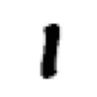

In [73]:
xb, yb = next(iter(full_train_loader))
show_image(xb[0, 0])

Use our trained model to classify this image, the prediction is 1, which is correct.

In [74]:
logits = larger_cnn(xb)
probs = logits.softmax(dim=1)
preds = probs.argmax(dim=1)
logits[0], probs[0], preds[0]

(tensor([-3.2632, 10.2683,  0.5308,  1.6681, -2.3475, -3.7332, -6.7423, -0.2727,
          4.8563, -0.7971], grad_fn=<SelectBackward0>),
 tensor([1.3222e-06, 9.9527e-01, 5.8747e-05, 1.8320e-04, 3.3034e-06, 8.2634e-07,
         4.0768e-08, 2.6305e-05, 4.4417e-03, 1.5571e-05],
        grad_fn=<SelectBackward0>),
 tensor(1))

# BatchNorm

Our results from the initial training is relatively good. We can improve the results by applying **Batch Normalization** to our convolution layer. The problem with convolutions is that nearly all activations start at 0. This will affect the training results. We want to apply normalization to the activations to improve the training results.

Batch normalization works by taking an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations. We also add two learnable parameters `gamma` and `beta` to accommodate extreme values. The new activation after applying batchnorm is `gamma*y + beta` where `y` is normalized activation. In pytorch, we use `nn.BatchNorm2d()` to apply batchnorm.

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)]
    if act:
        layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)


cnn_bn = nn.Sequential(
    conv(1, 8, ks=5),  # 14x14
    conv(8, 16),  # 7x7
    conv(16, 32),  # 4x4
    conv(32, 64),  # 2x2
    conv(64, 10, act=False),  # 1x1
    nn.Flatten(),
)

train(cnn_bn, 5e-2, 5, full_train_loader, full_valid_loader)

epoch 0, train loss: 0.2530
validation loss tensor(0.0933)
epoch 1, train loss: 0.0963
validation loss tensor(0.0649)
epoch 2, train loss: 0.0689
validation loss tensor(0.0540)
epoch 3, train loss: 0.0543
validation loss tensor(0.0429)
epoch 4, train loss: 0.0459
validation loss tensor(0.0395)


We can see that after applying the batch norm, the training loss goes down even further.